# Homework 02 - Unsupervised learning
*Neural Networks and Deep Learning* 
*Lecture by Prof. Alberto Testolin*\
*@ the University of Padova* \
*Winter term 2021/22* \

*Nathanael Schmidt-Ott* \
*Master student in Applied Statistics* \
*@ Göttingen University* \
*Guest Student at the univeristy of padova* 
 
ursnathanael.schmidtott@studenti.unipd.it

# Import functions and packages

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/MyDrive/NNDL_PD/HW_2/

Mounted at /content/gdrive
/content/gdrive/MyDrive/NNDL_PD/HW_2


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import random 
import os 
from tqdm import tqdm 
import time
import pickle

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
!pip install --quiet optuna
import optuna
from optuna.trial import TrialState

     |████████████████████████████████| 308 kB 10.3 MB/s 
     |████████████████████████████████| 81 kB 5.5 MB/s 
     |████████████████████████████████| 209 kB 26.4 MB/s 
     |████████████████████████████████| 78 kB 4.9 MB/s 
     |████████████████████████████████| 146 kB 37.2 MB/s 
     |████████████████████████████████| 112 kB 26.3 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 


In [ ]:
if not os.path.isdir("plots_autoencoder"):
  os.makedirs("plots_autoencoder")

if not os.path.isdir("ae_models"):
  os.makedirs("ae_models")

# Prepare the dataset

In [ ]:
# load the data
data_dir = "fashion_mnist_data"

transform_train = transforms.Compose([
  transforms.ToTensor(),                                    
])
transform_test = transforms.Compose([
  transforms.ToTensor(),                                    
])

train_data = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_data  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

# transform the data
train_data.transform = transform_train
test_data.transform = transform_test

# define the full train dataset
full_train_data = train_data

# split the training data into a validation set and a training set
n = len(train_data)
n_train = int(0.8 * n)
n_val = n - n_train

torch.manual_seed(2909)
train_data, val_data = torch.utils.data.random_split(train_data, [n_train, n_val])

print("Samples in full training data:",len(full_train_data))
print("Samples in training data:",len(train_data))
print("Samples in validation data:", len(val_data))
print("Samples in test data:",len(test_data))

Samples in full training data: 60000
Samples in training data: 48000
Samples in validation data: 12000
Samples in test data: 10000


In [ ]:
# define the Dataloader object
batch_size = 256
full_train_loader = DataLoader(full_train_data, batch_size = batch_size, shuffle = True)
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

# get shape of train and test loader
batch_data, batch_labels = next(iter(train_loader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(val_loader))
print(f"VALIDATION BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_loader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
VALIDATION BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


We see that each batch in the train and in the test loader corresponds to the batch size that we defined. Moreover, the images are greyscale, thus they have one channel. The images are 28 x 28 pixel images.
The shape of the label vector is 256 and corresponds to the batch size that we set. For each image in a batch, there is one label.

# Define the Autoencoder
The Autoencoder is a fully unsupervised algorithm. Thus, we do not need the labels of our data, but meerly focus on finding a latent representation of the input using an ENCODER and on reconstructing that input from the latent representation using the DECODER. Accordingly, the goal is to define the encoder and the decoder and then train the parameters of both. We can train the parameters using gradient descent and backpropagation of the loss. As loss we use the reconstruction loss, defined by the mean squarred error between the input image and the reconstructed image.

## The Encoder

Let's start by defining the encoder

In [ ]:
class Encoder(nn.Module):

  def __init__(self,latent_space_dim,dropout_rate = 0):
    super().__init__()

    # define the convolutional layers
    self.enc_cnn = nn.Sequential(
        # first convolutional layer
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4,
                  stride=2, padding=1), # outputs 14x14 pixel feature maps K*((W−F+2P)/(S+1)) = 1 * ((28 - 4 + 2*1)/(2) + 1) = 14
        nn.ReLU(inplace = True), # inplace True avoids the network from creating an additional output and thus saves memory
        
        # second convolutional layer
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 4,
                  stride = 2, padding = 1), # outputs 7 x 7 pixel feature maps
        nn.ReLU(True),
        
        # third convolutional layer
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3,
                  stride = 2, padding = 0), # outputs 3 x 3 pixel feature maps
        nn.ReLU(True)
    )

    # flatten the feature maps of the last convolutional layer
    self.flatten = nn.Flatten(start_dim = 1) # start dim = 1 avoids the network from flattening the batch size

    self.enc_linear = nn.Sequential(
        nn.Linear(in_features = 32 * 3 * 3, out_features = 64),
        nn.Dropout(dropout_rate),
        nn.ReLU(True),
        nn.Linear(in_features = 64, out_features = latent_space_dim)
    )
  
  def forward(self, x):
    # apply conv layers
    x = self.enc_cnn(x)
    # flatten x
    x = self.flatten(x)
    # apply linear layers
    x = self.enc_linear(x)
    return x

## The Decoder

The Encoder produces a vetor representation in R^2. Now lets define the decoder, which reconstructs the image from the latent representation... Even though it could take any shape, I define it completely symmetric to the encoder. 

In [ ]:
class Decoder(nn.Module):

  def __init__(self,latent_space_dim,dropout_rate = 0):
    super().__init__()

    # define the linear layers
    self.dec_linear = nn.Sequential(
        nn.Linear(in_features = latent_space_dim, out_features = 64),
        nn.Dropout(dropout_rate),
        nn.ReLU(True),
        nn.Linear(in_features = 64, out_features = 32 * 3 * 3),
        nn.Dropout(dropout_rate),
        nn.ReLU(True)
    )

    # reshape the output of the linear layer for the convolutional layers
    self.reshape_for_cnn = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

    # define the convolutional layers
    self.dec_cnn = nn.Sequential(
        # first convolutional layer
        nn.ConvTranspose2d(in_channels=32, out_channels = 16, kernel_size=3,
                  stride=2, padding=0),
        nn.ReLU(inplace = True), # inplace True avoids the network from creating an additional output and thus saves memory
        
        # second convolutional layer
        nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 4,
                  stride = 2, padding = 1), 
        nn.ReLU(True),
        
        # third convolutional layer
        nn.ConvTranspose2d(in_channels = 8, out_channels = 1, kernel_size = 4,
                  stride = 2, padding = 1)
    )

  def forward(self, x):
    # apply linear layers
    x = self.dec_linear(x)
    # unflatten x
    x = self.reshape_for_cnn(x)
    # apply conv layers
    x = self.dec_cnn(x)
    # apply sigmoid to get pixel values between 0 and 1
    x = torch.sigmoid(x)
    return x

# Fitting the basic Autoencoder

## Define the functions for training
Functions to train the basic autoencoder

In [ ]:
def train(dataloader, encoder, decoder, loss_fn, optimiser, device):
  encoder.train()
  decoder.train()
  for img_batch, _ in dataloader:
    # encode and decode the input
    img_batch = img_batch.to(device)
    latent_repr = encoder(img_batch)
    out = decoder(latent_repr)
    
    # calculate loss (representation loss - i.e. compare y_hat to x)
    loss = loss_fn(out,img_batch)

    # backwards pass
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

def validate(train_loader, encoder, decoder, loss_fn, device, val_loader = None):
    # define the lists where to store the original image and the reconstructed image
    orig_img = []
    rec_img = []
    encoder.eval()  # initialise validation mode
    decoder.eval()
    with torch.no_grad():  # disable gradient tracking
        if not val_loader is None:
          dataloader = val_loader
        else:
          dataloader = train_loader
        for img_batch, _ in dataloader:
            img_batch = img_batch.to(device)
            # forward pass
            latent_repr = encoder(img_batch)
            out = decoder(latent_repr) 
            # append to lists
            orig_img.append(img_batch.cpu())
            rec_img.append(out.cpu())
        orig_img = torch.cat(orig_img)
        rec_img = torch.cat(rec_img) 
        # loss
        val_loss = loss_fn(rec_img,orig_img)

    return val_loss.data.numpy()

# define a function to plot the progress of the training...
def plot_progress(img, encoder, decoder, epoch, dir):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
      rec_img = decoder(encoder(img))
    # plot the reconstructed and the original image
    fig, axs = plt.subplots(1,2, figsize = (10, 5))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    os.makedirs(dir, exist_ok=True)
    plot_name = str(dir)+'/epoch_'+str(epoch + 1)+'.png'
    fig.savefig(plot_name)
    plt.show()
    plt.close()

def plot_progress_sgl(img, encoder, decoder, epoch, dir):
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
      rec_img = decoder(encoder(img))
  # plot only the reconstructed image

def reconstruct_img(img, encoder, decoder):
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
      rec_img = decoder(encoder(img))
  rec_img = rec_img.squeeze(0).squeeze(0).cpu().numpy()
  return rec_img


# define the function to run training

def run_training(n_epochs, dataloader, ex_img, encoder, decoder, optimiser, loss_fn, device):
    '''
    Wrapper for training and validation
    :param n_epochs: number of epochs to train
    :param encoder: initialised Torch nn (nn.Module) ecoder
    :param decoder: initialised Torch nn (nn.Module) decoder
    :param optimiser: Torch optimiser object
    :param loss_fn: Torch loss function
    :param device: device to use (CPU, GPU)
    :return: training and validation loss
    '''
    print('Initialising training')
    start_time = time.time()
    val_loss = []
    rec_img = []

    for epoch in tqdm(range(n_epochs)):
      train(dataloader, encoder, decoder, loss_fn, optimiser, device)
      val_loss.append(validate(dataloader, encoder, decoder, loss_fn, device))  

      # plot progress for any image from the validation data
      ex_img = ex_img.to(device)
      rec_img.append(reconstruct_img(ex_img, encoder, decoder))    
      
    end_time = time.time()
    time_elapsed = np.round(end_time - start_time, 0).astype(int)
    print(f"Finished training after {time_elapsed} seconds")
    
    return val_loss, rec_img 

def init_weights_kaiming(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.kaiming_normal_(m.weight)

# plot reconstruction images for both models
def plot_reconstruction(rec_img_list, dir, nrows = 3, ncols = 3):
  n = len(rec_img_list)
  fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (7, 6))
  it = 0
  for j in ax.reshape(-1):
    _ = j.imshow(rec_img_list[it], cmap = 'gray')
    j.set_title("Epoch" + str(it+1))
    j.set_xticks([])
    j.set_yticks([])
    it += 1
  plt.tight_layout()
  plt.savefig(dir,dpi = 300)
  plt.show()


## Train the autoencoder

Lets train the autoencoder using the defined functions...

In [ ]:
## initialise the encoder and the decoder
encoder = Encoder(2,0)
decoder = Decoder(2,0)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### set manual_seed
torch.manual_seed(2909)

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimise = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

adam_lr = 5e-4
sgd_lr = 1e-3 # Learning rate

# training with regularisation
adam = torch.optim.Adam(params_to_optimise, lr=adam_lr, weight_decay=1e-5)
sgd = torch.optim.SGD(params_to_optimise, lr = sgd_lr, weight_decay = 1e-5) 

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# run the training
n_epochs = 42

# select an image for exemplary reconstruction
ex_img = next(iter(val_loader))
ex_img = ex_img[0][0].unsqueeze(0)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

# initialise weights  
encoder.apply(init_weights_kaiming)
decoder.apply(init_weights_kaiming)
val_loss_adam, rec_img_adam = run_training(n_epochs, train_loader, ex_img, encoder, decoder, adam, loss_fn, device)

#reinitialise weights to make both results comparable
encoder.apply(init_weights_kaiming)
decoder.apply(init_weights_kaiming)
val_loss_sgd, rec_img_sgd = run_training(n_epochs, train_loader, ex_img, encoder, decoder, sgd, loss_fn, device)

Selected device: cuda
Initialising training


100%|██████████| 42/42 [06:23<00:00,  9.13s/it]


Finished training after 383 seconds
Initialising training


100%|██████████| 42/42 [05:55<00:00,  8.45s/it]

Finished training after 355 seconds


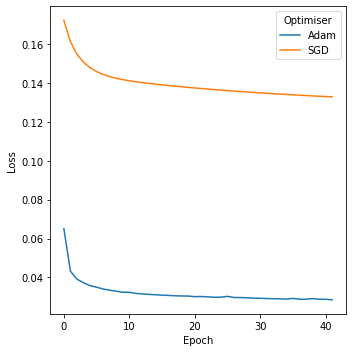

In [ ]:
plt.figure(figsize = (5,5))
plt.plot(val_loss_adam, label = 'Adam')
plt.plot(val_loss_sgd, label = 'SGD')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title = "Optimiser")
plt.tight_layout()
plt.savefig("plots_autoencoder/basic_implementation_loss.png", dpi = 300)
plt.show()

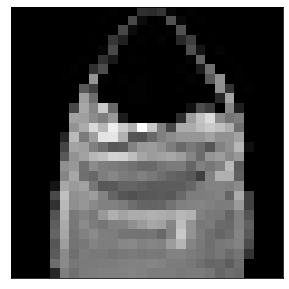

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(ex_img.squeeze(0).squeeze(0).numpy(),cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.savefig("plots_autoencoder/original_img.png", dpi = 300)
plt.show()

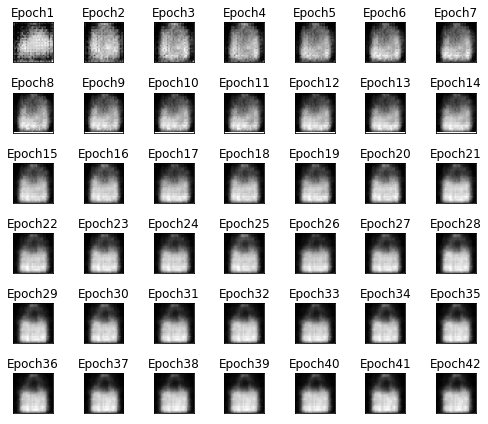

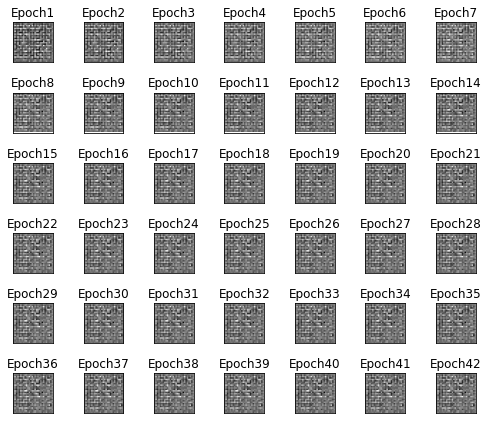

In [ ]:
rec_plot_adam = plot_reconstruction(rec_img_adam,dir = "plots_autoencoder/rec_img_adam.png",
                                    nrows = 6, ncols = 7)
rec_plot_sgd = plot_reconstruction(rec_img_sgd, dir = "plots_autoencoder/rec_img_sgd.png",
                                   nrows = 6, ncols = 7)

# Tuning hyper-parameters
To tune hyper-parameters I use the automatic tuninig tool Optuna. In total I consider 5 paramters to tune: (i) $d$ - the dimension of the latent space, (ii) $r$ - the dropout rate in the linear layers, (iii) $\alpha$ - the strength of the penalty of weight decay, (iv) - the optimiser (Adam, SGD)  and finally (v) $lr$ - the learning rate.

## Define the functions for hyper-parameter tuning

In [ ]:
# first we define a function which Optuna can directly use to initialise new models
# this step includes considering different architectural choices. In this case I only consider
# different values for the dimension of the latent space and for the dropout rate.
# Here the dimension of the latent space is an integer that varies between 2 and 100
# and the dropout rate is a float between 0 and 1
def optuna_model(trial):

  # the dropout rate
  dr = trial.suggest_float('dr',0,1)

  # dimension of the latent space
  d = trial.suggest_int('d',2,1000)
  # define the encoder and the decoder with the corresponding sampled parameters. 
  encoder = Encoder(d,dr)
  decoder = Decoder(d,dr)

  # return a sequential model of the encoder and the decoder
  return encoder, decoder


Now, define the training procedure for the network - or better the obejctive that I wish to minimise. The overall goal is to minimise the reconstruction error. Thus, I need to define every step for the model until I obtain the final loss. This includes defining the model, defining the optimiser, learning rate and so on and defining the training and the validation step. I use a validation set rather than cross-validation as the data is large and cross validation will increase computation times considerably.

In [ ]:
def objective(trial):

  # first define the model
  encoder, decoder = optuna_model(trial)
  encoder = encoder.to(device)
  decoder = decoder.to(device)
  encoder.apply(init_weights_kaiming)
  decoder.apply(init_weights_kaiming)
  params_to_optimise = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
    ]

  # sample hyper-parameters
  alpha = trial.suggest_float('alpha', 1e-5,0.2,log = True)
  lr = trial.suggest_float('lr',1e-5,1e-1, log = True)
  optimiser_name = trial.suggest_categorical('optimiser_name',["Adam","SGD"])
  # get the optimiser from torch.optim based on the sampled name
  optimiser = getattr(torch.optim, optimiser_name)(params_to_optimise, lr = lr, weight_decay = alpha)

  # define the training
  for epoch in tqdm(range(max_epochs)):
    # training step
    train(train_loader, encoder, decoder, loss_fn, optimiser, device)

    # validation step
    val_loss = validate(train_loader, encoder, decoder, loss_fn, device, val_loader)

    # now create the report
    trial.report(val_loss, epoch)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
  
  return val_loss

## Tune hyper-parameters

In [ ]:
# define the device
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# define number of epochs
max_epochs = 42

# define the number of trials
n_trials = 20

# define the study (i.e. the parameter serach study)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())

# run the study
study.optimize(objective, n_trials = n_trials)

# get some basic information on the pruned and completed trials
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# get the parameters for the best trial
best_trial = study.best_trial
print("Best prameters:")
for key, value in best_trial.params.items():
  print("\t{}: {}".format(key, value))

print("Lowest loss:")
print("\t {}".format(best_trial.value))

# save the best parameters
with open('ae_models/best_trial.pickle', 'wb') as f:
        pickle.dump(best_trial, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Study statistics: ")
print("\t # of total trials: ", len(study.trials))
print("\t # of pruned trials: ", len(pruned_trials))
print("\t # of completed trials: ", len(complete_trials))

[I 2022-06-20 07:58:22,041] A new study created in memory with name: no-name-70da20ae-0d8a-467b-ab77-0269b63712a9


Selected device: cuda


100%|██████████| 42/42 [03:57<00:00,  5.64s/it]
[I 2022-06-20 08:02:19,096] Trial 0 finished with value: 0.12897294759750366 and parameters: {'dr': 0.4324766776537252, 'd': 375, 'alpha': 0.04976814851191627, 'lr': 0.06974683382965405, 'optimiser_name': 'SGD'}. Best is trial 0 with value: 0.12897294759750366.
100%|██████████| 42/42 [03:39<00:00,  5.23s/it]
[I 2022-06-20 08:05:58,861] Trial 1 finished with value: 0.21934543550014496 and parameters: {'dr': 0.9911835117274969, 'd': 974, 'alpha': 3.530518769853582e-05, 'lr': 1.5106922701501875e-05, 'optimiser_name': 'SGD'}. Best is trial 0 with value: 0.12897294759750366.
100%|██████████| 42/42 [03:40<00:00,  5.26s/it]
[I 2022-06-20 08:09:39,715] Trial 2 finished with value: 0.1576954573392868 and parameters: {'dr': 0.06055488287898503, 'd': 725, 'alpha': 0.0004582685205130865, 'lr': 3.2338985102724736e-05, 'optimiser_name': 'SGD'}. Best is trial 0 with value: 0.12897294759750366.
100%|██████████| 42/42 [03:39<00:00,  5.24s/it]
[I 2022-06-2

Best prameters:
	dr: 0.004620206540670586
	d: 185
	alpha: 1.0383659257324325e-05
	lr: 0.005835253593725732
	optimiser_name: Adam
Lowest loss:
	 0.010114902630448341
Study statistics: 
	 # of total trials:  20
	 # of pruned trials:  6
	 # of completed trials:  14


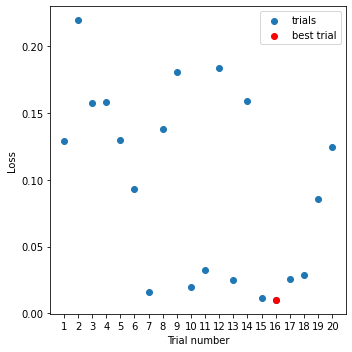

In [ ]:
# plot the different losses for the combination of parameters obtained in optuna
study_df =  study.trials_dataframe()

# save study_df as csv
study_df.to_csv('ae_models/optuna_study_results.csv')
losses = study_df['value']

plt.figure( figsize  = (5,5))
plt.scatter(x = range(1,len(losses)+1), y = losses, label = 'trials')
plt.scatter(x = best_trial.number + 1, y = best_trial.value, color = 'red', label = 'best trial')
plt.xlabel("Trial number")
plt.ylabel("Loss")
plt.xticks(list(range(1,21)))
plt.legend()
plt.tight_layout()
plt.savefig("plots_autoencoder/optuna_results_conv_ae.png", dpi = 300)
plt.show()

In [ ]:
optuna.visualization.plot_optimization_history(study, target_name = 'Validation loss' )

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study, target_name = 'Validation loss' )

## Fit the best model

In [ ]:
# load the best parameters
with open('ae_models/best_trial.pickle', 'rb') as f:
  best_trial = pickle.load(f)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

best_encoder = Encoder(best_trial.params['d'],best_trial.params['dr'])
best_decoder = Decoder(best_trial.params['d'],best_trial.params['dr'])

### Define the loss function
loss_fn = torch.nn.MSELoss()

# set number of epochs
n_epochs = 42

params_to_optimise = [
    {'params': best_encoder.parameters()},
    {'params': best_decoder.parameters()}
]

lr = best_trial.params['lr']
alpha = best_trial.params['alpha']
optimiser_name = best_trial.params['optimiser_name']
optimiser = getattr(torch.optim, optimiser_name)(params_to_optimise, lr = lr, weight_decay = alpha)

# select an image for exemplary reconstruction
ex_img = next(iter(val_loader))
ex_img = ex_img[0][0].unsqueeze(0)

# move encoder and decoder to device
best_encoder.to(device)
best_decoder.to(device)

# initialise weights  
best_encoder.apply(init_weights_kaiming)
best_decoder.apply(init_weights_kaiming)
val_loss_tuned, rec_img_tuned = run_training(n_epochs, train_loader, ex_img, best_encoder, best_decoder, optimiser, loss_fn, device)

# save network parameters for future use
torch.save(best_encoder.state_dict(), 'ae_models/best_encoder_params.pth')
torch.save(best_decoder.state_dict(), 'ae_models/best_decoder_params.pth')

Selected device: cuda
Initialising training


100%|██████████| 42/42 [06:16<00:00,  8.98s/it]


Finished training after 377 seconds


## Produce report outputs using the best model


In [ ]:
# to load I need to reinitalise the network in the same way 
with open('ae_models/best_trial.pickle', 'rb') as f:
  best_trial = pickle.load(f)

best_encoder = Encoder(best_trial.params['d'],best_trial.params['dr'])
best_decoder = Decoder(best_trial.params['d'],best_trial.params['dr'])

# load network parameters
best_encoder.load_state_dict(torch.load('ae_models/best_encoder_params.pth'))
best_decoder.load_state_dict(torch.load('ae_models/best_decoder_params.pth'))

<All keys matched successfully>

In [ ]:
# Do some image reconstructions using the best model on the validation set
first_batch = next(iter(val_loader))
ex_img_1 = first_batch[0][0].unsqueeze(0)
ex_img_2 = first_batch[0][1].unsqueeze(0)
ex_img_3 = first_batch[0][2].unsqueeze(0)

rec_img_1 = reconstruct_img(ex_img_1, best_encoder, best_decoder)
rec_img_2 = reconstruct_img(ex_img_2, best_encoder, best_decoder)
rec_img_3 = reconstruct_img(ex_img_3, best_encoder, best_decoder)

In [ ]:
def plot_rec_image(ex_img, rec_img, dir):
  ex_img = ex_img.squeeze(0).squeeze(0).numpy()
  fig, ax = plt.subplots(1,2,figsize = (8,4))
  ax[0].imshow(ex_img, cmap = 'gray')
  ax[0].set_title("Original image")
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[1].imshow(rec_img, cmap = 'gray')
  ax[1].set_title("Reconstructed image")
  ax[1].set_xticks([])
  ax[1].set_yticks([])
  plt.savefig(dir, dpi = 300)
  plt.show()


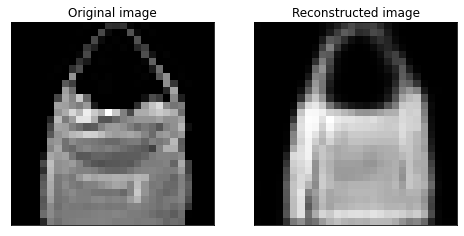

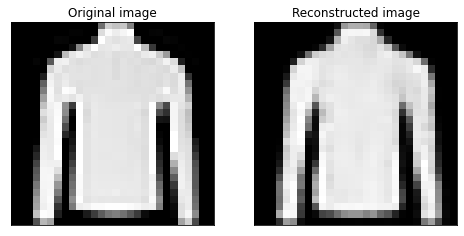

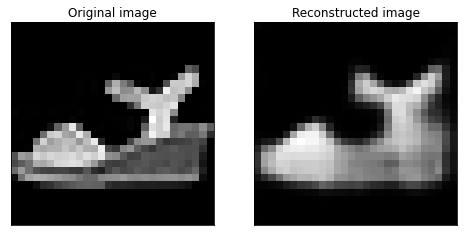

In [ ]:
plot_rec_image(ex_img_1, rec_img_1, "plots_autoencoder/ex_rec_1.png")
plot_rec_image(ex_img_2, rec_img_2, "plots_autoencoder/ex_rec_2.png")
plot_rec_image(ex_img_3, rec_img_3, "plots_autoencoder/ex_rec_3.png")

In [ ]:
## get hyper-parameters of second best runs etc.
optuna_study_results = pd.read_csv("ae_models/optuna_study_results.csv")

In [ ]:
optuna_study_results.sort_values(by = 'value')

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_alpha,params_d,params_dr,params_lr,params_optimiser_name,state
15,15,15,0.010115,2022-06-20 08:42:03.713102,2022-06-20 08:45:54.086203,0 days 00:03:50.373101,0.000010,185,0.004620,0.005835,Adam,COMPLETE
14,14,14,0.011468,2022-06-20 08:38:12.129544,2022-06-20 08:42:03.709997,0 days 00:03:51.580453,0.000012,249,0.034581,0.003540,Adam,COMPLETE
6,6,6,0.015953,2022-06-20 08:20:49.580803,2022-06-20 08:24:37.700622,0 days 00:03:48.119819,0.000108,815,0.039376,0.002251,Adam,COMPLETE
9,9,9,0.019840,2022-06-20 08:26:28.499922,2022-06-20 08:30:18.280927,0 days 00:03:49.781005,0.000042,853,0.075625,0.000039,Adam,COMPLETE
12,12,12,0.025117,2022-06-20 08:34:15.638565,2022-06-20 08:38:06.712770,0 days 00:03:51.074205,0.000086,822,0.316355,0.003670,Adam,COMPLETE
16,16,16,0.025404,2022-06-20 08:45:54.089449,2022-06-20 08:49:43.886742,0 days 00:03:49.797293,0.000011,192,0.353537,0.010312,Adam,COMPLETE
17,17,17,0.029005,2022-06-20 08:49:43.889707,2022-06-20 08:53:37.962882,0 days 00:03:54.073175,0.000507,254,0.164665,0.010000,Adam,COMPLETE
10,10,10,0.032229,2022-06-20 08:30:18.283981,2022-06-20 08:34:10.059562,0 days 00:03:51.775581,0.000288,66,0.501664,0.005159,Adam,COMPLETE
18,18,18,0.085846,2022-06-20 08:53:37.966331,2022-06-20 08:53:43.534667,0 days 00:00:05.568336,0.000012,65,0.727439,0.001398,Adam,PRUNED
5,5,5,0.092855,2022-06-20 08:16:59.524819,2022-06-20 08:20:49.577656,0 days 00:03:50.052837,0.002018,426,0.237551,0.037158,Adam,COMPLETE


# Supervised learning

Next I use the autoencoder to perform classification of the images. Thus, I use the trained encoder, which was trained in an unsupervised fashion and add a few fully connected layers, which take the latent space representation of the image as input and output the final prediction. 

## define training functions

In [ ]:
class MultipleOptimiser(object):
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

In [ ]:
# first define the new classifier (it is an MLP with two fully connected layers
# dropout and variable hidden unit size)

class MLP(nn.Module):
  
  def __init__(self, latent_space_dim = 2, No1=100, No2=100, dr = 0):
    super().__init__()
    
    self.linear = nn.Sequential(
        nn.Linear(in_features = latent_space_dim, out_features = No1),
        nn.Dropout(dr),
        nn.ReLU(True),
        nn.Linear(in_features = No1, out_features = No2),
        nn.Dropout(dr),
        nn.ReLU(True),
        nn.Linear(in_features = No2, out_features = 10)
    )
  
  def forward(self, x):
    out = self.linear(x)
    return out

In [ ]:
# define training functions
def cl_train(dataloader, encoder, classifier, loss_fn, optimiser, device):
  y = []
  t = []
  
  encoder.train()
  classifier.train()
  for img_batch, t_batch in dataloader:
    # encode and decode the input
    img_batch = img_batch.to(device)
    t_batch = t_batch.to(device)
    latent_repr = encoder(img_batch)
    out = classifier(latent_repr)
    
    loss = loss_fn(out,t_batch)

    # backwards pass
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    y.append(out)
    t.append(t_batch)
  y = torch.cat(y)
  t = torch.cat(t)
  y_max = y.argmax(dim = 1)
  train_loss = loss_fn(y,t)
  train_acc = sum(y_max == t)/len(y_max)
  return train_loss.data.cpu().numpy(), train_acc.data.cpu().numpy()


def cl_validate(val_loader, encoder, classifier, loss_fn, device, get_preds = False):
    y = []
    t = []
    
    encoder.eval()  # initialise validation mode
    classifier.eval()
    with torch.no_grad():  # disable gradient tracking
        for img_batch, t_batch in val_loader:
            t_batch = t_batch.to(device)
            img_batch = img_batch.to(device)
            # forward pass
            latent_repr = encoder(img_batch)
            out = classifier(latent_repr) 
            y.append(out)
            t.append(t_batch)
        y = torch.cat(y)
        y_max = y.argmax(dim = 1)
        t = torch.cat(t) 
        # loss
        val_loss = loss_fn(y,t)
        val_acc = sum((y_max == t))/len(y_max)
    if get_preds == True:
      return val_loss.data.cpu().numpy(),val_acc.data.cpu().numpy(),y_max.cpu(),t.cpu()
    else:
      return val_loss.data.cpu().numpy(), val_acc.data.cpu().numpy()

In [ ]:
# define the model for optuna
def cl_optuna_model(trial):

  # the dropout rate
  mlp_dr = trial.suggest_float('mlp_dr',0,.2)

  # size of No1 and No2
  No1 = trial.suggest_int('No1',10,100)
  No2 = trial.suggest_int('No2',10,100)
  
  # define the encoder and the decoder with the corresponding sampled parameters. 
  encoder = best_encoder
  classifier = MLP(best_trial.params['d'], No1 = No1, No2 = No2, dr = mlp_dr)

  # return a sequential model of the encoder and the decoder
  return encoder, classifier

def cl_objective(trial):

  ### first define the model
  encoder, classifier = cl_optuna_model(trial)
  encoder = encoder.to(device)
  classifier = classifier.to(device)
  classifier.apply(init_weights_kaiming)
  enc_params = encoder.parameters()
  cl_params = classifier.parameters()

  ### use the best learning parameters for the encoder
  enc_lr = best_trial.params['lr']
  enc_alpha = best_trial.params['alpha']
  enc_optimiser_name = best_trial.params['optimiser_name']
  enc_optimiser = getattr(torch.optim, enc_optimiser_name)(enc_params, lr = enc_lr, weight_decay = enc_alpha)

  ### sample parameters for the MLP
  mlp_lr = trial.suggest_float('mlp_lr',1e-5, 1e-1, log = True)
  mlp_alpha = trial.suggest_float('mlp_alpha',1e-5,0.2, log = True)
  mlp_optimiser_name = trial.suggest_categorical('mlp_optimiser_name',["Adam","SGD"])
  mlp_optimiser = getattr(torch.optim, mlp_optimiser_name)(cl_params, lr = mlp_lr, weight_decay = mlp_alpha)

  ### define a single optimiser object
  optimiser = MultipleOptimiser(enc_optimiser,
                                mlp_optimiser)
  ### define the loss function
  ce_loss = torch.nn.CrossEntropyLoss()

  ### define the training
  for epoch in tqdm(range(max_epochs)):
    # training step
    train_loss, train_acc = cl_train(train_loader, encoder, classifier, ce_loss, optimiser, device)

    # validation step
    val_loss, val_acc = cl_validate(val_loader, encoder, classifier, ce_loss, device)

    # now create the report
    trial.report(val_acc, epoch)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
  
  return val_acc

## Optimise Hyper-parameters

In [ ]:
# load the best encoder and corresponding hyper-parameters
# to load I need to reinitalise the network in the same way 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

with open('ae_models/best_trial.pickle', 'rb') as f:
  best_trial = pickle.load(f)

best_encoder = Encoder(best_trial.params['d'],best_trial.params['dr'])

# load network parameters
best_encoder.load_state_dict(torch.load('ae_models/best_encoder_params.pth', map_location=torch.device(device)))

Selected device: cuda


<All keys matched successfully>

In [ ]:
# optimise hyper-parameters using optuna for the MLP
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# set seed
torch.manual_seed(2909)

# define number of epochs
max_epochs = 10

# define the number of trials
n_trials = 20

# define the study (i.e. the parameter serach study)
cl_study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

# run the study
cl_study.optimize(cl_objective, n_trials = n_trials)

# get some basic information on the pruned and completed trials
cl_pruned_trials = cl_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
cl_complete_trials = cl_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# save the best parameter combination
cl_best_trial = cl_study.best_trial

with open('ae_models/cl_best_trial.pickle', 'wb') as f:
        pickle.dump(cl_best_trial, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Study statistics: ")
print("\t # of total trials: ", len(cl_study.trials))
print("\t # of pruned trials: ", len(cl_pruned_trials))
print("\t # of completed trials: ", len(cl_complete_trials))

[I 2022-06-20 09:55:24,944] A new study created in memory with name: no-name-f79971e2-ba42-4639-8d30-ca253db34683


Selected device: cuda


100%|██████████| 10/10 [01:01<00:00,  6.19s/it]
[I 2022-06-20 09:56:26,820] Trial 0 finished with value: 0.890583336353302 and parameters: {'mlp_dr': 0.053646788156667416, 'No1': 73, 'No2': 86, 'mlp_lr': 5.631172223726883e-05, 'mlp_alpha': 4.500487411029287e-05, 'mlp_optimiser_name': 'Adam'}. Best is trial 0 with value: 0.890583336353302.
100%|██████████| 10/10 [00:58<00:00,  5.81s/it]
[I 2022-06-20 09:57:24,912] Trial 1 finished with value: 0.42208331823349 and parameters: {'mlp_dr': 0.18903818150515003, 'No1': 76, 'No2': 61, 'mlp_lr': 0.07565263650989651, 'mlp_alpha': 0.0006418289763582612, 'mlp_optimiser_name': 'Adam'}. Best is trial 0 with value: 0.890583336353302.
100%|██████████| 10/10 [00:57<00:00,  5.80s/it]
[I 2022-06-20 09:58:22,907] Trial 2 finished with value: 0.8995833396911621 and parameters: {'mlp_dr': 0.16777866083599033, 'No1': 95, 'No2': 49, 'mlp_lr': 0.0031187374302863737, 'mlp_alpha': 0.001341665807840227, 'mlp_optimiser_name': 'SGD'}. Best is trial 2 with value: 0.

Study statistics: 
	 # of total trials:  20
	 # of pruned trials:  12
	 # of completed trials:  8


## Use the tuned model on test data

In [ ]:
# load the best model, run it on the training data
with open('ae_models/cl_best_trial.pickle', 'rb') as f:
  cl_best_trial = pickle.load(f)

In [ ]:
cl_best_trial.params

{'No1': 12,
 'No2': 74,
 'mlp_alpha': 0.16797746467029528,
 'mlp_dr': 0.06764223076407054,
 'mlp_lr': 0.0001801812982210931,
 'mlp_optimiser_name': 'Adam'}

In [ ]:
best_mlp = MLP(
    latent_space_dim = best_trial.params['d'],
    No1 = cl_best_trial.params['No1'],
    No2 = cl_best_trial.params['No2'],
    dr = cl_best_trial.params['mlp_dr']
)

In [ ]:
# fit the best model on the full training data
### get the model parameters for the mlp and the encoder
enc_params = best_encoder.parameters()
mlp_params = best_mlp.parameters()

### use the best learning parameters for the encoder
enc_lr = best_trial.params['lr']
enc_alpha = best_trial.params['alpha']
optimiser_name = best_trial.params['optimiser_name']
enc_optimiser = getattr(torch.optim, optimiser_name)(enc_params, lr = enc_lr, weight_decay = enc_alpha)

### sample parameters for the MLP
mlp_lr = cl_best_trial.params['mlp_lr']
mlp_alpha = cl_best_trial.params['mlp_alpha']
mlp_optimiser_name = cl_best_trial.params['mlp_optimiser_name']
mlp_optimiser = getattr(torch.optim, mlp_optimiser_name)(mlp_params, lr = mlp_lr, weight_decay = mlp_alpha)

### define a single optimiser object
optimiser = MultipleOptimiser(enc_optimiser,
                              mlp_optimiser)

### define the loss function
ce_loss = nn.CrossEntropyLoss()

### define the max number of epochs
max_epochs = 10

### move to device
best_encoder.to(device)
best_mlp.to(device)

# set seed 
torch.manual_seed(2909)

### run training for the best model on the full data
start_time = time.time()
train_loss_l = []
train_acc_l = []
for epoch in tqdm(range(max_epochs)):
    # training step
    train_loss, train_acc = cl_train(full_train_loader, best_encoder, best_mlp, ce_loss, optimiser, device)
    train_loss_l.append(train_loss)
    train_acc_l.append(train_acc)
end_time = time.time()
time_elapsed = np.round(end_time - start_time, 0).astype(int)
print(f"Finished training after {time_elapsed} seconds") 
### save the best_encoder and the best_mlp
torch.save(best_encoder.state_dict(), 'ae_models/final_encoder_params.pth')
torch.save(best_mlp.state_dict(), 'ae_models/final_mlp_params.pth')

100%|██████████| 10/10 [01:00<00:00,  6.10s/it]

Finished training after 61 seconds


In [ ]:
# Evaluate the performance on the test data

### load the tuned hyper-parameters
with open('ae_models/cl_best_trial.pickle', 'rb') as f:
  mlp_best_trial = pickle.load(f)

with open('ae_models/best_trial.pickle', 'rb') as f:
  enc_best_trial = pickle.load(f)

### generate the models
final_encoder = Encoder(
    latent_space_dim = enc_best_trial.params['d'],
    dropout_rate = enc_best_trial.params['dr']
)

final_mlp = MLP(
    latent_space_dim = enc_best_trial.params['d'],
    No1 = mlp_best_trial.params['No1'],
    No2 = mlp_best_trial.params['No2'],
    dr = mlp_best_trial.params['mlp_dr']
)

### load the final encoder and mlp parameters
final_encoder.load_state_dict(torch.load('ae_models/final_encoder_params.pth'))
final_mlp.load_state_dict(torch.load('ae_models/final_mlp_params.pth'))

final_encoder.to(device)
final_mlp.to(device)


### define the loss function
ce_loss = nn.CrossEntropyLoss()

### test the final model on the test set
test_loss, test_acc, preds, labs = cl_validate(test_loader, final_encoder, final_mlp, ce_loss, device, get_preds = True)

In [ ]:
### get predictions for each image in the test set
from sklearn.metrics import classification_report

lab_dict = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

classes = list(lab_dict.values())
print(classification_report(labs,preds, digits = 4, target_names = classes))

class_report = pd.DataFrame(classification_report(y_true = labs, y_pred = preds, digits = 4, target_names = classes, output_dict = True)).T
# subset class report to report only the F1 score and prepare output for report...
class_report = class_report.iloc[:,[2,3]]
print(class_report.to_latex(index = False, caption = "Classification report on test set", label = 'tab:class_report_test', float_format = "%.4f"))
print(cl_best_trial.params)

              precision    recall  f1-score   support

 T-shirt/Top     0.8561    0.8510    0.8536      1000
     Trouser     0.9859    0.9790    0.9824      1000
    Pullover     0.8293    0.8310    0.8302      1000
       Dress     0.9214    0.8790    0.8997      1000
        Coat     0.8282    0.8530    0.8404      1000
      Sandal     0.9779    0.9750    0.9765      1000
       Shirt     0.7224    0.7340    0.7282      1000
     Sneaker     0.9645    0.9510    0.9577      1000
         Bag     0.9721    0.9760    0.9741      1000
  Ankle Boot     0.9561    0.9790    0.9674      1000

    accuracy                         0.9008     10000
   macro avg     0.9014    0.9008    0.9010     10000
weighted avg     0.9014    0.9008    0.9010     10000

\begin{table}
\centering
\caption{Classification report on test set}
\label{tab:class_report_test}
\begin{tabular}{rr}
\toprule
 f1-score &    support \\
\midrule
   0.8536 &  1000.0000 \\
   0.9824 &  1000.0000 \\
   0.8302 &  1000.0000 \\


# Exploring the latent space

Next I explore the latent space of the autoencoder. First I reduce dimensions using PCA and TSNE and then I generate new samples from that latent space.

## load the final encoder and the final decoder


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

with open('ae_models/best_trial.pickle', 'rb') as f:
  best_trial = pickle.load(f)

# load the trained encoder
final_encoder = Encoder(best_trial.params['d'], best_trial.params['dr'])
final_encoder.load_state_dict(torch.load('ae_models/best_encoder_params.pth', map_location=torch.device(device)))
final_encoder.to(device)

# load the trained decoder
final_decoder = Decoder(best_trial.params['d'], best_trial.params['dr'])
final_decoder.load_state_dict(torch.load('ae_models/best_decoder_params.pth', map_location=torch.device(device)))
final_decoder.to(device)

Selected device: cpu


Decoder(
  (dec_linear): Sequential(
    (0): Linear(in_features=185, out_features=64, bias=True)
    (1): Dropout(p=0.004620206540670586, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0.004620206540670586, inplace=False)
    (5): ReLU(inplace=True)
  )
  (reshape_for_cnn): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (dec_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

## Reducing dimensions

First get the latent representations of the images in the test set. To do so I use the trained encoder with optimised hyper-parameters

In [ ]:
# get the latent representations
final_encoder.eval()
latent_reps = []
target = []
with torch.no_grad():
  for img_batch, t_batch in test_loader:
    img_batch = img_batch.to(device)
    t_batch = t_batch.to(device)
    lat_rep = final_encoder(img_batch)
    # append to list
    latent_reps.append(lat_rep.cpu())
    target.append(t_batch.cpu())

latent_reps = torch.cat(latent_reps).numpy()
target = torch.cat(target).numpy()

In [ ]:
# show latent representations
# each row is a latent representation of an input image.
pd.DataFrame(latent_reps)

,0,1,2,3,4,5,6,7,8,9,...,175,176,177,178,179,180,181,182,183,184
0,-0.002759,-0.004069,-0.017460,0.032502,1.355095,0.064467,0.020378,-0.368593,0.029654,-0.520428,...,0.114590,-1.266080,-2.051463,0.278698,0.140368,-0.045322,0.122398,-1.238187,0.111782,0.150020
1,0.214258,-0.007508,0.143862,0.355840,1.988087,0.011209,-0.426103,-1.317137,0.177422,-2.131406,...,-0.388200,0.287027,-0.030344,-0.244891,-0.035844,-0.052520,-0.757530,-1.308078,-0.037437,3.897006
2,0.097936,0.088280,0.059062,0.309179,-1.798151,0.024113,-0.031519,3.907754,0.074868,-0.615337,...,-0.173654,-0.451721,-0.075938,0.955260,0.094334,-0.026743,-0.210690,-1.288693,0.047242,7.318065
3,0.094955,0.014000,0.091370,0.148274,0.888985,0.020733,-0.170051,-0.443746,0.008919,-0.864561,...,-0.099150,0.323678,0.463009,1.415750,0.106607,-0.025716,-0.389430,-1.088664,-0.013502,3.808360
4,-0.023913,-0.026089,0.095295,0.150504,-0.184407,0.003269,-0.016641,-1.277089,0.067394,0.278284,...,-0.024741,1.355621,0.537032,0.999396,-0.035966,-0.038774,0.096381,-0.326848,-0.019640,3.042159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.032225,-0.036810,0.051747,0.204727,0.838683,0.032619,-0.176272,-0.850348,0.122682,-0.746797,...,-0.054665,1.132003,-0.789295,0.414644,0.026247,-0.070138,-0.250342,0.954649,0.026827,-4.897565
9996,0.097774,-0.002287,0.057304,0.159426,0.870282,0.028092,-0.042147,0.747503,0.080461,0.114632,...,-0.093977,0.640833,-0.804897,0.678908,0.087696,-0.031741,-0.238594,0.795790,0.046814,3.114331
9997,0.134015,0.025974,0.058864,0.126801,0.481192,0.050292,-0.069527,-1.089892,0.094152,-1.046138,...,-0.047838,-0.295632,2.842919,-0.240062,0.159236,-0.048369,0.418409,1.756982,0.135816,-0.669725
9998,0.175895,-0.001885,0.081500,0.289373,0.249316,-0.013165,0.021109,-0.448619,0.104138,-1.199680,...,-0.289101,0.689130,-3.514654,0.364877,0.040050,-0.046062,-0.107500,3.126697,0.017119,3.810881


In [ ]:
# Run a PCA to reduce the dimension of the latent space to 2, such that we can nicely plot it
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_res = pca.fit_transform(latent_reps)
print(pca.explained_variance_ratio_)

[0.22207558 0.15745503]


In [ ]:
# define color sequence for plotting
color_dict = {
    0:"b",1:'g',2:'r',3:'c',4:'m',5:'y',6:'brown',7:'orange', 8:'darkgreen',9:'gray'}

color_coded_targets = [color_dict[t] for t in target]

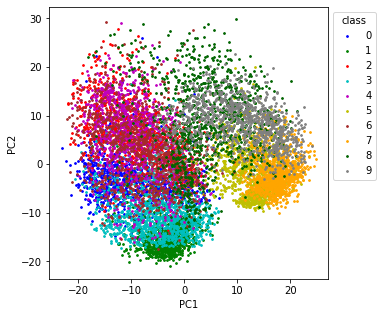

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
for t in np.unique(target):
    ix = np.where(target == t)
    ax.scatter(pca_res[ix,0], pca_res[ix,1], c = color_dict[t], label = t, s = 3)
ax.legend(title = 'class',ncol = 1,bbox_to_anchor= (1,1))
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.savefig("plots_autoencoder/pca.png",dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
# run TSNE to reduce dimensions
from sklearn import manifold 
np.random.seed(2909)
tsne = manifold.TSNE(n_components = 2, init = 'pca', learning_rate = 'auto',perplexity=40)
tsne_res = tsne.fit_transform(latent_reps)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


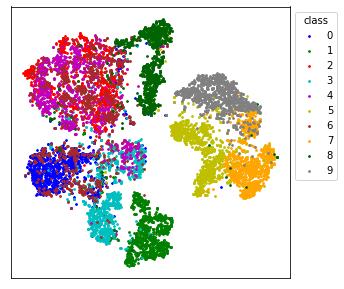

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
for t in np.unique(target):
    ix = np.where(target == t)
    ax.scatter(tsne_res[ix,0], tsne_res[ix,1], c = color_dict[t], label = t, s = 3)
ax.legend(title = 'class',ncol = 1,bbox_to_anchor= (1,1))
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("plots_autoencoder/tsne.png",dpi = 300, bbox_inches = 'tight')
plt.show()

## Generating new samples
Next I turn to generating new samples from the latent space.

In [ ]:

# just generate random samples from the latent space (wich is R^d).
def get_random_sample(d,mini,maxi):
  sample = np.random.uniform(mini,maxi,d)
  return sample

def encode_sample(encoder, sample, device):
  encoder.eval()
  sample = sample.unsqueeze(0).to(device)
  with torch.no_grad():
    z = encoder(sample).detach().cpu().numpy()
  return z

def decode_sample(decoder,sample, device):
  decoder.eval()
  sample = torch.tensor(sample).float().to(device)
  sample = sample.unsqueeze(0)
  with torch.no_grad():
    out = decoder(sample).squeeze(0).squeeze(0).cpu().numpy()
  return out

In [ ]:
# get a random sample
# restrict the sampling space to the minimum and maximum obtained in the latent
# representations of the test set
mini = min([min(h) for h in latent_reps])
maxi = max([max(h) for h in latent_reps])
np.random.seed(2909)
# generate 10 new samples
new_samples = []
new_imgs = []
for i in range(10):
  sample = get_random_sample(best_trial.params['d'],mini,maxi)
  new_samples.append(sample)
  
  # decode the random sample
  new_imgs.append(decode_sample(final_decoder,sample, device))

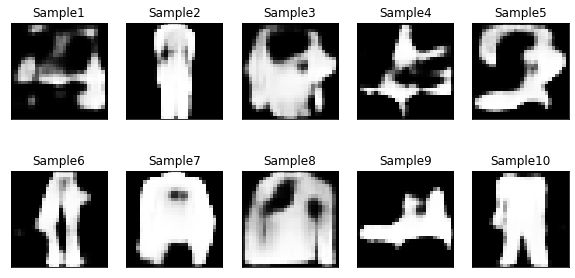

In [ ]:
# plot random samples
fig, ax = plt.subplots(2,5, figsize = (10,5))
it = 0
for j in ax.reshape(-1):
  _ = j.imshow(new_imgs[it], cmap = 'gray')
  j.set_xticks([])
  j.set_yticks([])
  j.set_title("Sample"+str(it+1))
  it += 1

plt.savefig("plots_autoencoder/new_samples.png", dpi = 300)

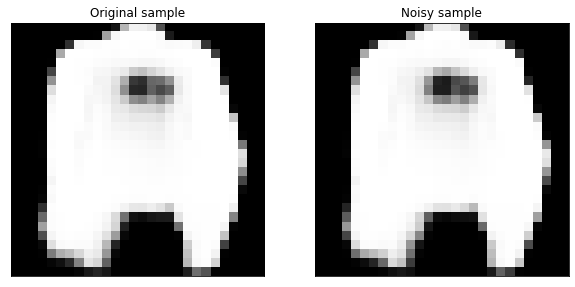

In [ ]:
# sample 7 seems to be quite a good sample, now check how smooth the latent space is
def add_noise(sample,lb,ub):
  noise = np.random.uniform(lb,ub,len(sample))
  noisy_sample = sample + noise
  return noisy_sample

sample = new_samples[6]
noisy_sample = add_noise(sample,-1,1)

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(decode_sample(final_decoder, sample, device),cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Original sample")

ax[1].imshow(decode_sample(final_decoder, noisy_sample, device),cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Noisy sample")
plt.savefig('plots_autoencoder/latent_space_regularity.png',dpi = 300)
plt.show()


Judging from this image, the latent space does not seem to bee to irregular...

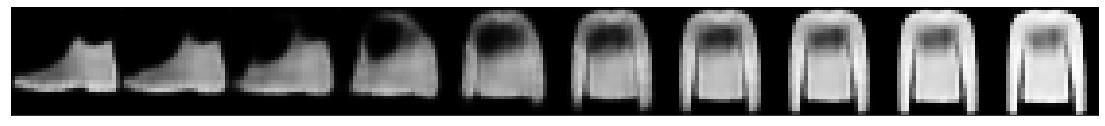

In [ ]:
# create image transversals
torch.manual_seed(2909)
imgs = next(iter(test_loader))
x1 = imgs[0][0].to(device)
x2 = imgs[0][1].to(device)

n = 10

z_1 = encode_sample(final_encoder,x1, device)
z_2 = encode_sample(final_encoder,x2, device)

z = torch.tensor(np.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])).to(device)

interpolate_list = []
for z_i in z:
    interpolate_list.append(final_decoder(z_i).detach().cpu().numpy())

img = np.zeros((28,n*28))
for i, x_hat in enumerate(interpolate_list):
    img[:, i*28:(i+1)*28] = x_hat.reshape(28, 28)
plt.figure(figsize = (20,2))
plt.imshow(img,cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.savefig("plots_autoencoder/ae_transversal.png",dpi = 300)
plt.show()

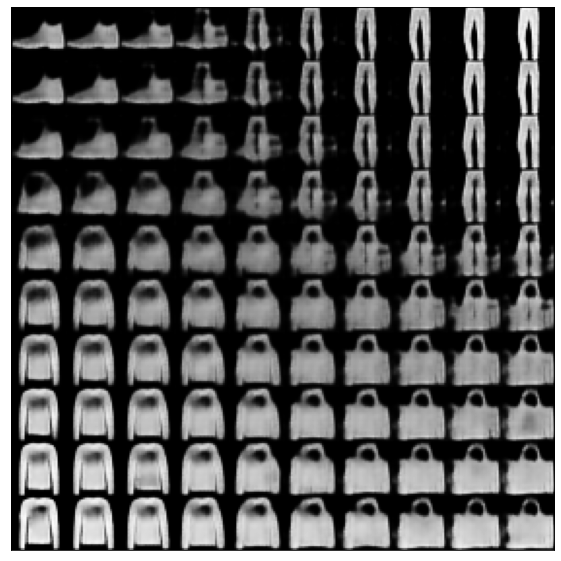

In [ ]:
torch.manual_seed(2909)
imgs = next(iter(test_loader))
x1 = imgs[0][0]
x2 = imgs[0][1]
x3 = imgs[0][2]
x4 = imgs[0][30]

z_1 = torch.tensor(encode_sample(final_encoder,x1, device)).to(device)
z_2 = torch.tensor(encode_sample(final_encoder,x2, device)).to(device)
z_3 = torch.tensor(encode_sample(final_encoder,x3, device)).to(device)
z_4 = torch.tensor(encode_sample(final_encoder,x4, device)).to(device)

n = 10

left = torch.stack([z_1 + (z_3 - z_1)*t for t in np.linspace(0, 1, n)])
right = torch.stack([z_2 + (z_4 - z_2)*t for t in np.linspace(0, 1, n)])
z_grid = torch.stack([left + (right - left)*t for t in np.linspace(0, 1, n)])
interpolate_list = []
for i in range(z_grid.shape[0]):
  for j in range(z_grid.shape[1]):
    interpolate_list.append(final_decoder(z_grid[i,j,:,:]).detach().cpu().numpy())

img = np.zeros((n*28,n*28))
it = 0
for i in range(n):
  for j in range(n):
    img[i*28:(i+1)*28, j*28:(j+1)*28] = interpolate_list[it].reshape(28,28)
    it += 1
plt.figure(figsize = (10,10))
plt.imshow(img,cmap = "gray")
plt.xticks([])
plt.yticks([])
if dir is not None:
  plt.savefig('plots_autoencoder/ae_transversal_grid.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# Variational Autoencoder
Finally, I fit a variational autoencoder, which is a truly generative model and can produce new samples by design...

## Define the Variational Autoencoder

In [ ]:
# need to adapt the Encoder, since it now should produce a mean and variance
# vector, which constitute the mean and variance of the multivariate gaussian
# that we sample from...

# The Decoder is the same as in the usual Autoencoder model, thus no need to adapt it.

class VarEncoder(nn.Module):

  def __init__(self,latent_space_dim):
    super().__init__()

    # define the convolutional layers
    self.enc_cnn = nn.Sequential(
        # first convolutional layer
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4,
                  stride=2, padding=1), # outputs 14x14 pixel feature maps K*((W−F+2P)/(S+1)) = 1 * ((28 - 4 + 2*1)/(2) + 1) = 14
        nn.ReLU(inplace = True), # inplace True avoids the network from creating an additional output and thus saves memory
        
        # second convolutional layer
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 4,
                  stride = 2, padding = 1), # outputs 7 x 7 pixel feature maps
        nn.ReLU(True),
        
        # third convolutional layer
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3,
                  stride = 2, padding = 0), # outputs 3 x 3 pixel feature maps
        nn.ReLU(True)
    )

    # flatten the feature maps of the last convolutional layer
    self.flatten = nn.Flatten(start_dim = 1) # start dim = 1 avoids the network from flattening the batch size

    # the latent space should consist of two vecotrs, where the vectors correspond to 
    # mean and variance for the sampling distribution - a multivariate normal distribution
    # Note, that the latent dimensions are considered to be independent and thus
    # the covariance matrix is diagonal

    self.enc_linear = nn.Sequential(
        nn.Linear(in_features = 32 * 3 * 3, out_features = 64),
        nn.ReLU(True)
    )
    self.mean_layer = nn.Linear(in_features = 64, out_features = latent_space_dim)
    self.var_layer = nn.Linear(in_features = 64, out_features = latent_space_dim)
  
  def forward(self, x):
    # apply conv layers
    x = self.enc_cnn(x)
    # flatten x
    x = self.flatten(x)
    # apply linear layer
    x = self.enc_linear(x)
    # generate mean and variance of the multivariate gaussian
    mn = self.mean_layer(x)
    vr = self.var_layer(x)
    return mn, vr

In [ ]:
class VAE(nn.Module):
  '''
  A wrapper for the encoder and the decoder functions, which takes care of the sampling
  '''

  def __init__(self, latent_space_dim = 2, device = torch.device("cpu")):
        super().__init__()
        self.encoder = VarEncoder(latent_space_dim)
        self.decoder = Decoder(latent_space_dim, dropout_rate = 0)
        self.device = device
        self.latent_space_dim = latent_space_dim
  
  def sample(self, mu, var):
    # sample from standard normal
    batch_size = mu.shape[0]
    sample = torch.normal(0,1,size = (batch_size, self.latent_space_dim)).to(device)
    sd = torch.sqrt(torch.exp(var)) # get the standard deviation from the log-variance...
    z = sd * sample + mu
    return z
  
  def forward(self, x):
    mu, var = self.encoder(x)
    z = self.sample(mu, var)
    out = self.decoder(z)
    return out
  
  def get_latent(self, x):
    mu,var = self.encoder(x)
    z = self.sample(mu, var)
    return z

  def vae_loss(self, out, x, mu, var):
    '''
    The loss for the variational autoencoder is a sum of the reconstruction loss and the
    kulback-leiber distance between the standard normal distribution and the fitted normal distribution
    '''
    reconstruction_loss = nn.MSELoss(reduction='sum')(out,x)
    kld_divergence = torch.sum(-0.5 * torch.sum(1 + var - torch.square(mu) - torch.exp(var), 1))
    loss = reconstruction_loss + torch.absolute(kld_divergence)
    return loss  

  def vae_train(self, train_loader, optimiser):
    # set the training mode
    self.train()
    for img_batch, _ in train_loader:
      # do a forward pass
      img_batch = img_batch.to(self.device)
      mu, var = self.encoder(img_batch)
      z = self.sample(mu, var)
      out = self.decoder(z)

      # calculate the loss
      batch_loss = self.vae_loss(out, img_batch, mu, var)
      optimiser.zero_grad()
      batch_loss.backward()
      optimiser.step()

  def vae_validate(self, val_loader):
    self.eval()
    val_loss = []
    with torch.no_grad():
      for img_batch, _ in val_loader:
        img_batch = img_batch.to(self.device)
        # forward pass
        mu, var = self.encoder(img_batch)
        z = self.sample(mu, var)
        out = self.decoder(z)

        # calculate the loss
        batch_loss = self.vae_loss(out, img_batch, mu, var)
        val_loss.append(batch_loss)

    val_loss = torch.tensor(val_loss).cpu().numpy()    
    return np.mean(val_loss)
    
  def run_training(self,train_loader,val_loader,optimiser,n_epochs = 42, ex_img = None, get_train_loss = True):
    # send model to device
    self.to(device) 
    print('Initialising training')
    start_time = time.time()
    train_loss = []
    val_loss = []
    rec_img = []

    for epoch in tqdm(range(n_epochs)):
      self.vae_train(train_loader = train_loader, optimiser = optimiser)
      val_loss.append(self.vae_validate(val_loader))
      if get_train_loss:
        train_loss.append(self.vae_validate(train_loader))    

      if ex_img is not None:
        # if an exemplary image is provided, store the progress of the image...
        ex_img = ex_img.to(device)
        rec_img.append(self.forward(ex_img).detach().cpu().squeeze(0).squeeze(0).numpy())

    end_time = time.time()
    time_elapsed = np.round(end_time - start_time, 0).astype(int)
    print(f"Finished training after {time_elapsed} seconds")

    return np.array(train_loss), np.array(val_loss), rec_img


  def interpolate(self, x_1, x_2, n=10, dir = None):
    z_1 = self.get_latent(x_1.to(self.device))
    z_2 = self.get_latent(x_2.to(self.device))
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)]) # going from one image to the other in n steps
    interpolate_list = []
    for z_i in z:
        interpolate_list.append(self.decoder(z_i).detach().cpu().numpy())
    # make one image by concatenating the different interpolations
    img = np.zeros((28,n*28))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*28:(i+1)*28] = x_hat.reshape(28, 28)
    plt.figure(figsize = (20,2))
    plt.imshow(img,cmap = "gray")
    plt.xticks([])
    plt.yticks([])
    if dir is not None:
      plt.savefig(dir, dpi = 300)

  def plot_latent_space(self, x_1, x_2, x_3, x_4, n = 10, dir = None):
    z_1 = self.get_latent(x_1.to(self.device))
    z_2 = self.get_latent(x_2.to(self.device))
    z_3 = self.get_latent(x_3.to(self.device))
    z_4 = self.get_latent(x_4.to(self.device))
    left = torch.stack([z_1 + (z_3 - z_1)*t for t in np.linspace(0, 1, n)])
    right = torch.stack([z_2 + (z_4 - z_2)*t for t in np.linspace(0, 1, n)])
    z_grid = torch.stack([left + (right - left)*t for t in np.linspace(0, 1, n)])
    interpolate_list = []
    for i in range(z_grid.shape[0]):
      for j in range(z_grid.shape[1]):
        interpolate_list.append(self.decoder(z_grid[i,j,:,:]).detach().cpu().numpy())

    img = np.zeros((n*28,n*28))
    it = 0
    for i in range(n):
      for j in range(n):
        img[i*28:(i+1)*28, j*28:(j+1)*28] = interpolate_list[it].reshape(28,28)
        it += 1
    plt.figure(figsize = (10,10))
    plt.imshow(img,cmap = "gray")
    plt.xticks([])
    plt.yticks([])
    if dir is not None:
      plt.savefig(dir, dpi = 300, bbox_inches = 'tight')
    plt.show()


## Tune hyper-parameters of the VAE

In [ ]:
def optuna_vae(trial):
  # dimension of the latent space
  d = trial.suggest_int('d',2,100)
  # define the VAE with the corresponding parameter
  vae = VAE(d, device)
  return vae

def objective(trial):

  # first define the model
  vae = optuna_vae(trial).to(device)

  # sample hyper-parameters
  alpha = trial.suggest_float('alpha', 1e-5,0.2,log = True)
  lr = trial.suggest_float('lr',1e-5,1e-1, log = True)
  # get the optimiser from torch.optim based on the sampled name
  optimiser = torch.optim.Adam(vae.parameters(), lr = lr, weight_decay = alpha)

  # define the training
  for epoch in tqdm(range(max_epochs)):
    vae.vae_train(train_loader = train_loader, optimiser = optimiser)
    val_loss = vae.vae_validate(val_loader)   

    # now create the report
    trial.report(val_loss, epoch)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
  
  return val_loss

In [ ]:
# define the device
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# set seed 
torch.manual_seed(2909)

# define number of epochs
max_epochs = 42

# define the number of trials
n_trials = 20

# define the study (i.e. the parameter serach study)
vae_study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())

# run the study
vae_study.optimize(objective, n_trials = n_trials)

# get some basic information on the pruned and completed trials
vae_pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
vae_complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

vae_best_trial = vae_study.best_trial
# save the best parameters
with open('ae_models/vae_best_trial.pickle', 'wb') as f:
        pickle.dump(vae_best_trial, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Study statistics: ")
print("\t # of total trials: ", len(vae_study.trials))
print("\t # of pruned trials: ", len(vae_pruned_trials))
print("\t # of completed trials: ", len(vae_complete_trials))

[I 2022-06-20 12:12:01,536] A new study created in memory with name: no-name-2edd6226-646e-4c82-bb54-c7e496ec7afc


Selected device: cuda


100%|██████████| 42/42 [03:57<00:00,  5.67s/it]
[I 2022-06-20 12:16:10,716] Trial 0 finished with value: 6560.39697265625 and parameters: {'d': 27, 'alpha': 0.00011901292987056003, 'lr': 0.012005824006229524}. Best is trial 0 with value: 6560.39697265625.
100%|██████████| 42/42 [04:11<00:00,  5.99s/it]
[I 2022-06-20 12:20:22,183] Trial 1 finished with value: 8860.4931640625 and parameters: {'d': 13, 'alpha': 0.10450950316125845, 'lr': 2.443362036957207e-05}. Best is trial 0 with value: 6560.39697265625.
100%|██████████| 42/42 [03:58<00:00,  5.67s/it]
[I 2022-06-20 12:24:20,393] Trial 2 finished with value: 7146.9228515625 and parameters: {'d': 72, 'alpha': 0.0025677684331574017, 'lr': 0.00013926679206996753}. Best is trial 0 with value: 6560.39697265625.
100%|██████████| 42/42 [03:55<00:00,  5.60s/it]
[I 2022-06-20 12:28:15,664] Trial 3 finished with value: 6225.35986328125 and parameters: {'d': 44, 'alpha': 0.00026164616186297727, 'lr': 0.001856181556748805}. Best is trial 3 with valu

Study statistics: 
	 # of total trials:  20
	 # of pruned trials:  13
	 # of completed trials:  7


In [ ]:
print("Best prameters:")
for key, value in vae_best_trial.params.items():
  print("\t{}: {}".format(key, value))

print("Lowest loss:")
print("\t {}".format(vae_best_trial.value))

Best prameters:
	d: 44
	alpha: 0.00026164616186297727
	lr: 0.001856181556748805
Lowest loss:
	 6225.35986328125


## Train the VAE with tuned hyper-parameters

In [ ]:
# load the study results
with open("ae_models/vae_best_trial.pickle", 'rb') as f:
  vae_best_trial = pickle.load(f)

In [ ]:
# get the training device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# set seed
torch.manual_seed(2909)

# number of epochs
n_epochs = 42

# first define the VAE
vae = VAE(latent_space_dim = vae_best_trial.params['d'], device = device)
vae_params = vae.parameters()

# define the optimiser
adam = torch.optim.Adam(vae_params, lr =  vae_best_trial.params['lr'], weight_decay = vae_best_trial.params['alpha'])

# provide an example image for image reconstruction
ex_img = next(iter(val_loader))
ex_img = ex_img[0][0].unsqueeze(0)

# run training
train_loss, val_loss, rec_img_vae = vae.run_training(train_loader, val_loader, adam, n_epochs, ex_img, get_train_loss = True)

### save the tuned vae
torch.save(vae.state_dict(), 'ae_models/final_vae.pth')

Selected device: cuda
Initialising training


100%|██████████| 42/42 [06:37<00:00,  9.47s/it]

Finished training after 398 seconds


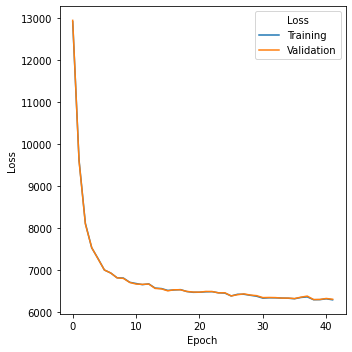

In [ ]:
# plot the loss functions
plt.figure(figsize = (5,5))
plt.plot(train_loss, label = 'Training')
plt.plot(val_loss, label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title = "Loss")
plt.tight_layout()
plt.savefig("plots_autoencoder/vae_loss.png", dpi = 300)
plt.show()

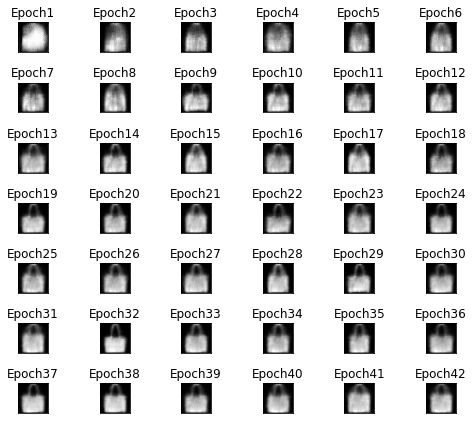

In [ ]:
plot_reconstruction(rec_img_vae, dir = "plots_autoencoder/rec_img_vae.png", nrows = 7, ncols = 6)

## plot results

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

with open('ae_models/vae_best_trial.pickle', 'rb') as f:
  vae_best_trial = pickle.load(f)

# load the trained encoder
final_vae = VAE(vae_best_trial.params['d'], device = device)
final_vae.load_state_dict(torch.load('ae_models/final_vae.pth', map_location=torch.device(device)))
final_vae.to(device)

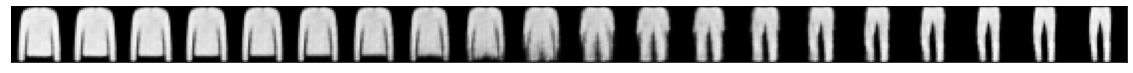

In [ ]:
# plot image transversal
# this plots how the latent representation of an image changes across the latent space
# until another latent representation of an image is reached...
torch.manual_seed(2909)
imgs = next(iter(test_loader))
x1 = imgs[0][1].unsqueeze(0)
x2 = imgs[0][2].unsqueeze(0)
final_vae.interpolate(x1,x2,20, dir = "plots_autoencoder/img_transversal_vae.png")

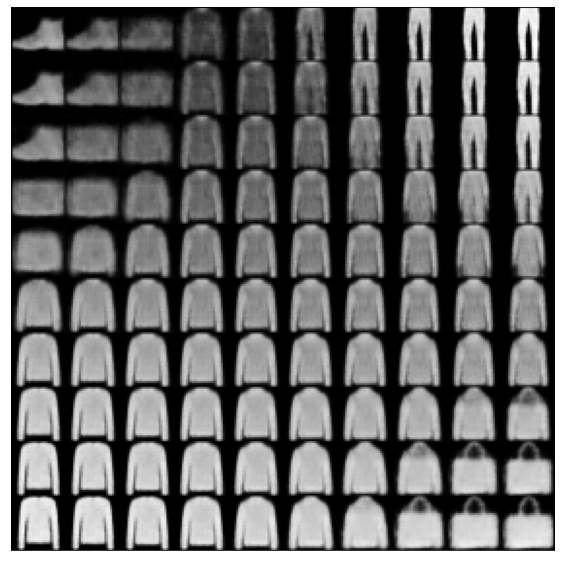

In [ ]:
torch.manual_seed(2909)
imgs = next(iter(test_loader))
x1 = imgs[0][0].unsqueeze(0)
x2 = imgs[0][1].unsqueeze(0)
x3 = imgs[0][2].unsqueeze(0)
x4 = imgs[0][30].unsqueeze(0)
final_vae.plot_latent_space(x1,x2,x3,x4, 10, dir = 'plots_autoencoder/vae_transversal_grid.png')

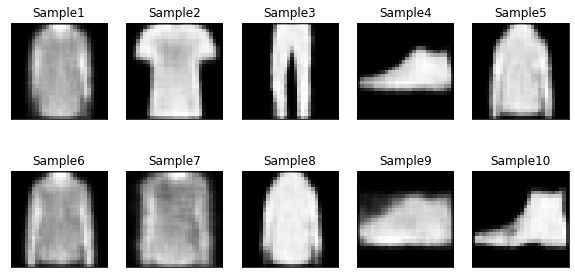

In [ ]:
# generate new samples from the VAE
# sample from a standard normal
torch.manual_seed(2909)
sample = torch.normal(0,1,size = (10, 44)).to(device)
new_samples = []
for z in sample:
  final_vae.decoder.eval()
  with torch.no_grad():
    out = final_vae.decoder(z.unsqueeze(0))
    out = out.cpu().numpy().reshape(28,28)
    new_samples.append(out)

fig, ax = plt.subplots(2,5, figsize = (10,5))
it = 0
for j in ax.reshape(-1):
  _ = j.imshow(new_samples[it], cmap = 'gray')
  j.set_xticks([])
  j.set_yticks([])
  j.set_title("Sample"+str(it+1))
  it += 1

plt.savefig("plots_autoencoder/new_samples_vae.png", dpi = 300)